In [145]:
import sys
import os
import pandas as pd
import numpy as np
import random
import scipy
from importlib import reload
import matplotlib.pyplot as plt
from matplotlib import patches
import seaborn as sns
import networkx as nx
from scipy import sparse
import gget
import time

import warnings
warnings.simplefilter("ignore", category=RuntimeWarning)

source_path = os.path.abspath("../source/")
sys.path.append(source_path)
import plotting as plt2

# Load scores + expression

In [2]:
""" CENTRALITY """
resolution = 1000000
fpath = f"/scratch/indikar_root/indikar1/shared_data/higher_order/global_core_score/population_mESC_{resolution}_scores.csv"
scores = pd.read_csv(fpath)
print(f"{scores.shape=}")

""" EXPRESSION """
fpath = "/scratch/indikar_root/indikar1/shared_data/higher_order/expression_table/rna_table.parquet"
tdf = pd.read_parquet(fpath)
print(f"(raw) {tdf.shape=}")
print(f"(filtered) {tdf.shape=}")

expression_map = dict(zip(tdf['gene_name'].values, tdf['TPM'].values))

tdf.sample(5)

scores.shape=(2431, 36)
(raw) tdf.shape=(51883, 19)
(filtered) tdf.shape=(51883, 19)


,gene_id,transcript_id(s),length,effective_length,expected_count,TPM,FPKM,posterior_mean_count,posterior_standard_deviation_of_count,pme_TPM,pme_FPKM,TPM_ci_lower_bound,TPM_ci_upper_bound,TPM_coefficient_of_quartile_variation,FPKM_ci_lower_bound,FPKM_ci_upper_bound,FPKM_coefficient_of_quartile_variation,ens_gene_id,gene_name
42166,ENSMUSG00000107966.1,ENSMUST00000203158.1,3773.0,3521.24,0.00,0.00,0.00,0.00,0.00,0.02,0.02,8.314690e-08,0.059400,0.659049,6.502930e-08,0.046453,0.659090,ENSMUSG00000107966,Gm44001
49699,ENSMUSG00000115829.1,ENSMUST00000228236.1,1426.0,1174.24,0.00,0.00,0.00,0.02,0.13,0.06,0.05,1.473630e-08,0.183605,0.653107,1.152190e-08,0.143597,0.653179,ENSMUSG00000115829,4921515G04Rik
17465,ENSMUSG00000062582.6,ENSMUST00000076166.6,345.0,95.84,1.01,0.78,0.58,1.02,0.16,1.48,1.16,3.501580e-02,3.496730,0.473657,3.163630e-02,2.737840,0.473670,ENSMUSG00000062582,Rpl30-ps8
21169,ENSMUSG00000076505.1,ENSMUST00000103306.1,362.0,111.93,0.00,0.00,0.00,0.00,0.00,0.63,0.49,2.777520e-07,1.870370,0.659485,2.171230e-07,1.463050,0.659300,ENSMUSG00000076505,Igkv1-131
7001,ENSMUSG00000028964.14,"ENSMUST00000030805.13,ENSMUST00000105673.7,ENS...",898.9,647.14,4423.00,506.17,377.48,4423.00,0.00,481.62,376.55,4.671420e+02,496.246000,0.010326,3.653500e+02,388.059000,0.010309,ENSMUSG00000028964,Park7


# Load gene-gene interactions

In [3]:
""" LOAD the TF list """
fpath = "/nfs/turbo/umms-indikar/shared/projects/twin_cell/data/b_matrix/SCENIC/scenic/tf_lists/allTFs_mm.txt"
tf_list = [x.strip() for x in open(fpath)]

""" LOAD the genes """
fpath = f"/scratch/indikar_root/indikar1/shared_data/higher_order/lightweight/population_mESC_{resolution}_gdf.parquet"
df = pd.read_parquet(fpath)
df['is_tf'] = df['gene_name'].isin(tf_list)

""" MERGE the core scores """
merge_columns = [
    'bin_name',
    'ATACSeq_1',
    'CTCF',
    'H3K27ac', 
    'H3K27me3',
    'RNA_5',
    'global_hge_logexp_RNA_weighted'
]

df = pd.merge(
    df, scores[merge_columns].fillna(0.0), how="left",
)

""" DEFINE the core """
order_threshold = 3
score_column = 'global_hge_logexp_RNA_weighted'
core_threshold_quantile = 0.75
threshold = np.quantile(df[score_column].fillna(0.0), core_threshold_quantile)
df['is_core'] = df[score_column].fillna(0.0) > threshold

""" ADD expression """
df['expression'] = df['gene_name'].map(expression_map)
df['order'] = df.groupby('read_name')['gene_name'].transform('nunique')

print(f"{df.shape=}")
df.head()

df.shape=(4939267, 14)


,gene_name,gene_biotype,read_name,bin_name,is_tf,ATACSeq_1,CTCF,H3K27ac,H3K27me3,RNA_5,global_hge_logexp_RNA_weighted,is_core,expression,order
0,Ulk4,protein_coding,3891ee6d-53d1-4ee0-ba2f-3d22291d4493,chr9:121,False,0.826484,1.149226,1.349552,0.866066,0.573875,0.254849,False,4.12,2
1,Smarca2,protein_coding,66953ddf-e76d-4cdf-aaf8-be028a2d7b04,chr19:26,False,0.497386,0.547185,0.336787,0.839273,0.141617,0.157878,False,4.55,11
2,Dlgap3,protein_coding,ad5b2240-893f-4ed0-a157-c2be66d8d754,chr4:127,False,0.754788,1.027046,1.577616,0.839461,0.906364,0.491722,True,87.94,5
3,Gm56531,lncRNA,3f354c45-5e48-4f6d-8c7e-05369432b344,chr12:8,False,0.690311,0.851758,0.774613,0.833768,0.617768,0.310082,False,NaN,1
4,Twsg1,protein_coding,d4626feb-16a2-4aac-8145-53e89b60bf7c,chr17:66,False,0.767515,0.921479,1.337415,0.571748,0.508463,0.289030,False,23.16,1


# Load SCENIC

In [4]:
fpath = "/nfs/turbo/umms-indikar/shared/projects/DGC/data/processed_data/MOUSE_10kbp_up_10kbp_down_B.csv"
sdf = pd.read_csv(fpath)
print(f"(raw) {sdf.shape=}")
sdf = sdf.rename(columns={'Unnamed: 0' : 'gene_name'})
sdf['gene_name'] = sdf['gene_name'].str.title()
sdf = sdf[sdf['gene_name'].isin(df['gene_name'].unique())]

sdf = sdf.set_index('gene_name')
sdf.columns = [x.title() for x in sdf.columns]

keep_columns = sdf.columns[sdf.columns.isin(df['gene_name'].unique())]
sdf = sdf[keep_columns]

print(f"(filtered) {sdf.shape=}")
sdf.head()

(raw) sdf.shape=(24130, 1606)
(filtered) sdf.shape=(15871, 938)


,Abl1,Adnp,Adnp2,Aebp2,Aff4,Ahctf1,Ahdc1,Ahr,Ahrr,Aire,...,Zscan21,Zscan22,Zscan25,Zscan26,Zscan29,Zscan30,Zxda,Zxdb,Zxdc,Zzz3
gene_name,,,,,,,,,,,,,,,,,,,,,
0610005C13Rik,5.32,3.31,4.930,0.0655,12.50,8.31,4.375000,2.8724,0.0,0.00,...,2.275,0.0,0.0,5.380000,2.255,0.0,0.00,0.00,0.00,2.37
0610009L18Rik,2.74,5.09,0.484,0.0000,15.90,10.40,4.528125,2.4820,0.0,0.00,...,2.695,0.0,0.0,2.382000,3.780,0.0,1.36,1.36,0.68,4.39
0610010K14Rik,2.28,4.48,3.470,0.0000,7.74,4.34,1.166600,2.3560,0.0,0.00,...,0.580,0.0,0.0,3.943333,1.795,0.0,0.00,0.00,0.00,1.98
0610030E20Rik,4.55,4.72,3.110,0.0000,8.23,6.63,3.365000,2.2320,0.0,0.00,...,1.445,0.0,0.0,3.172667,3.325,0.0,0.00,0.00,0.00,2.39
0610031O16Rik,9.30,10.80,1.500,0.0000,13.90,15.60,6.348750,2.8440,0.0,0.76,...,2.951,0.0,0.0,5.020000,2.705,0.0,0.00,0.00,0.00,5.26


In [161]:
def summarize_dataframe(sdf, top_n=5):
  """
  Prints summary statistics of a Pandas DataFrame, focusing on the top N 
  columns and rows based on their mean values. Uses pandas to create 
  tables for column and row statistics.

  Args:
    sdf: The input Pandas DataFrame.
    top_n: The number of top rows and columns to analyze.
  """

  print("DataFrame Summary Statistics (Top {} Rows and Columns):".format(top_n))
  print("-" * 50)

  # Select top N columns by mean value
  top_cols = sdf.mean().sort_values(ascending=False).head(top_n).index
  sdf_top_cols = sdf[top_cols]

  # Select top N rows by mean value
  top_rows = sdf.mean(axis=1).sort_values(ascending=False).head(top_n).index
  sdf_top_rows = sdf.loc[top_rows]

  print("Overall (Top Columns):")
  print(f"  Max: {np.max(sdf_top_cols):.2f}")
  print(f"  Min: {np.min(sdf_top_cols):.2f}")
  print(f"  Mean: {np.mean(sdf_top_cols):.2f}")
  print(f"  Median: {np.median(sdf_top_cols):.2f}") 

  # --- Create DataFrame for column-wise statistics ---
  col_stats = pd.DataFrame({
      "Max": sdf_top_cols.max(),
      "Min": sdf_top_cols.min(),
      "Mean": sdf_top_cols.mean(),
      "Median": sdf_top_cols.median()
  })
  print("\nColumn-wise Statistics (Top Columns):\n", col_stats.to_markdown(numalign="left", stralign="left"))

  # --- Create DataFrame for row-wise statistics ---
  row_stats = pd.DataFrame({
      "Max": sdf_top_rows.max(axis=1),
      "Min": sdf_top_rows.min(axis=1),
      "Mean": sdf_top_rows.mean(axis=1),
      "Median": sdf_top_rows.median(axis=1)
  })
  row_stats.index = top_rows  # Set correct row indices
  print("\nRow-wise Statistics (Top Rows):\n", row_stats.to_markdown(numalign="left", stralign="left"))

# Example usage:
# Assuming 'sdf' is your DataFrame
summarize_dataframe(sdf, top_n=10)  # Analyze top 10 rows and columns

DataFrame Summary Statistics (Top 10 Rows and Columns):
--------------------------------------------------
Overall (Top Columns):
  Max: 277.00
  Min: 0.00
  Mean: 22.00
  Median: 15.93

Column-wise Statistics (Top Columns):
 |        | Max   | Min       | Mean    | Median   |
|:-------|:------|:----------|:--------|:---------|
| Mta3   | 277   | 0.203     | 33.8119 | 26.1     |
| Wrnip1 | 232   | 0         | 26.5862 | 20.1     |
| Rcor1  | 232   | 0         | 26.5862 | 20.1     |
| Ezh2   | 249   | 0.516     | 23.3083 | 18.7     |
| Aff4   | 172   | 0.264     | 20.0072 | 15.8     |
| Egr4   | 197   | 0         | 18.2927 | 12       |
| Sp7    | 186   | 0         | 18.0598 | 11.9     |
| Klf15  | 181   | 0.0270667 | 17.7782 | 12.6333  |
| Zgpat  | 191   | 0         | 17.7774 | 11.845   |
| Klf2   | 159   | 0.1707    | 17.759  | 12.82    |

Row-wise Statistics (Top Rows):
 | gene_name     | Max   | Min   | Mean    | Median   |
|:--------------|:------|:------|:--------|:---------|
| Setd

In [5]:
# build a look-up table
gene_reads = df.groupby('gene_name')['read_name'].apply(list)
core_map = df.groupby('gene_name')['is_core'].max()

results = []

start_time = time.time()  # Record the start time

for i, tf in enumerate(sdf.columns):
    reads = gene_reads[tf]

    group = df[df['read_name'].isin(reads) & df['gene_name'].isin(sdf.index)]
    tf_genes = group['gene_name'].unique()

    # mean observed
    mask = sdf.index.isin(tf_genes)
    global_tf_score = sdf[tf].mean()

    # Add a t-test here based on the mask
    observed = sdf.loc[mask, tf]  # TF scores for genes in the hyperedge
    unobserved = sdf.loc[~mask, tf] # TF scores for genes NOT in the hyperedge
    _, p_value_obs = scipy.stats.ttest_ind(observed, unobserved)
    _, p_valu_glob = scipy.stats.ttest_ind(observed, sdf[tf])

    row = {
        'tf' : tf,
        'tf_is_core' : core_map[tf],
        'tf_expression' : expression_map[tf],
        'n_hyperedges' : len(reads),
        'n_genes' : len(tf_genes),
        'scenic_score' : global_tf_score,
        'observed_score' : observed.mean(),
        'unobserved_score' : unobserved.mean(),
        'p_value_over_unobserved': p_value_obs,
        'p_value_over_global': p_valu_glob,
        'group_expression' : group['expression'].mean(),
        'percent_core' : group['is_core'].sum() / len(group),
    }
    results.append(row)

    # Print periodic status updates
    if (i+1) % 100 == 0:  # Print every 10 iterations
        elapsed_time = time.time() - start_time
        print(f"Processed {i+1} transcription factors in {elapsed_time:.2f} seconds.")
        
results = pd.DataFrame(results)
print()
results.head()

Processed 100 transcription factors in 82.61 seconds.
Processed 200 transcription factors in 179.68 seconds.
Processed 300 transcription factors in 276.76 seconds.
Processed 400 transcription factors in 362.98 seconds.
Processed 500 transcription factors in 495.91 seconds.
Processed 600 transcription factors in 614.59 seconds.
Processed 700 transcription factors in 698.17 seconds.
Processed 800 transcription factors in 780.02 seconds.
Processed 900 transcription factors in 861.94 seconds.



,tf,tf_is_core,tf_expression,n_hyperedges,n_genes,scenic_score,observed_score,unobserved_score,p_value_over_unobserved,p_value_over_global,group_expression,percent_core
0,Abl1,False,58.36,520,705,8.200628,9.120213,8.157880,2.431880e-13,2.704756e-12,36.712161,0.157215
1,Adnp,False,31.30,43,50,5.836200,6.252000,5.834886,2.544285e-01,2.556126e-01,24.576216,0.144144
2,Adnp2,False,27.26,107,103,2.888309,3.076117,2.887083,3.811649e-01,3.840158e-01,20.344911,0.120536
3,Aebp2,False,44.12,758,848,0.392775,0.474113,0.388184,3.956752e-03,6.677611e-03,28.207555,0.136770
4,Aff4,True,38.17,283,377,20.007214,26.298170,19.854143,2.055963e-18,2.274579e-17,29.989342,0.637255


/tmp/ipykernel_2533085/1551561782.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


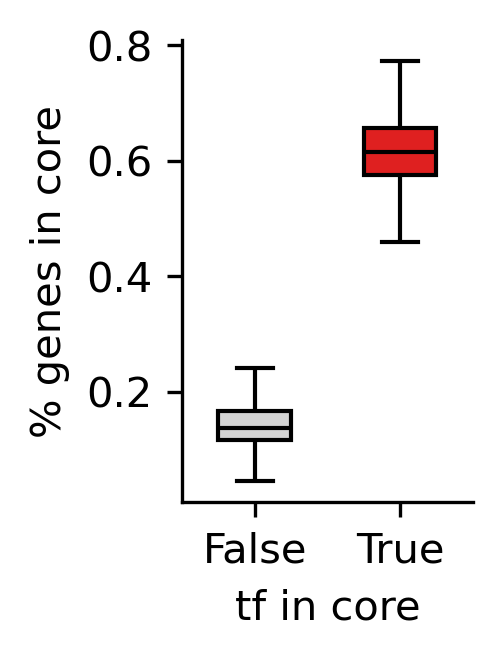

In [6]:
plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = 1.25, 2

sns.boxplot(
    data=results,
    x='tf_is_core',
    y='percent_core',
    linecolor='k',
    showfliers=False,
    width=0.5,
    palette=['lightgrey', 'red'],
)

plt.xlabel('tf in core')
plt.ylabel('% genes in core')

sns.despine()

In [7]:
results.head()

,tf,tf_is_core,tf_expression,n_hyperedges,n_genes,scenic_score,observed_score,unobserved_score,p_value_over_unobserved,p_value_over_global,group_expression,percent_core
0,Abl1,False,58.36,520,705,8.200628,9.120213,8.157880,2.431880e-13,2.704756e-12,36.712161,0.157215
1,Adnp,False,31.30,43,50,5.836200,6.252000,5.834886,2.544285e-01,2.556126e-01,24.576216,0.144144
2,Adnp2,False,27.26,107,103,2.888309,3.076117,2.887083,3.811649e-01,3.840158e-01,20.344911,0.120536
3,Aebp2,False,44.12,758,848,0.392775,0.474113,0.388184,3.956752e-03,6.677611e-03,28.207555,0.136770
4,Aff4,True,38.17,283,377,20.007214,26.298170,19.854143,2.055963e-18,2.274579e-17,29.989342,0.637255


/tmp/ipykernel_2533085/3475592485.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


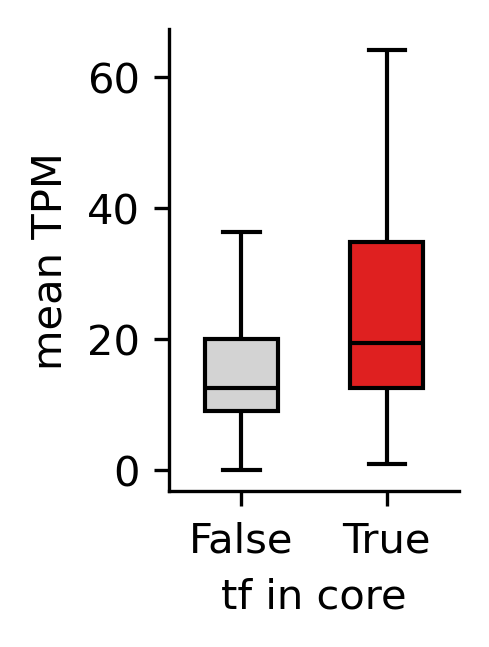

In [8]:
plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = 1.25, 2

sns.boxplot(
    data=results,
    x='tf_is_core',
    y='group_expression',
    linecolor='k',
    showfliers=False,
    width=0.5,
    palette=['lightgrey', 'red'],
)

plt.xlabel('tf in core')
plt.ylabel('mean TPM')

sns.despine()

/tmp/ipykernel_2533085/285993247.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


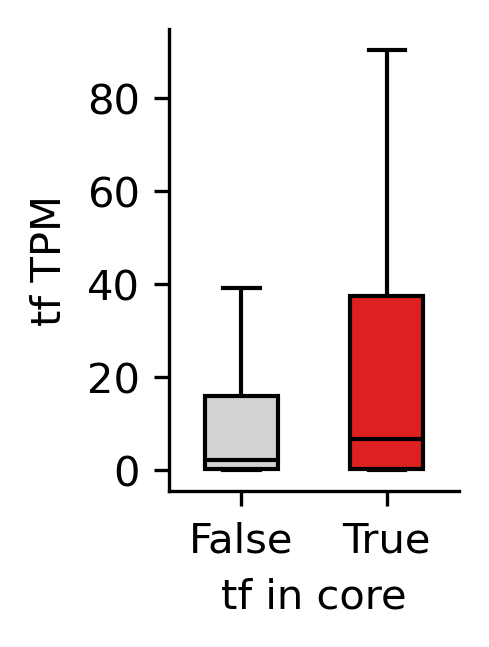

In [9]:
plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = 1.25, 2

sns.boxplot(
    data=results,
    x='tf_is_core',
    y='tf_expression',
    linecolor='k',
    showfliers=False,
    width=0.5,
    palette=['lightgrey', 'red'],
)

plt.xlabel('tf in core')
plt.ylabel('tf TPM')

sns.despine()

In [10]:
results.head()

,tf,tf_is_core,tf_expression,n_hyperedges,n_genes,scenic_score,observed_score,unobserved_score,p_value_over_unobserved,p_value_over_global,group_expression,percent_core
0,Abl1,False,58.36,520,705,8.200628,9.120213,8.157880,2.431880e-13,2.704756e-12,36.712161,0.157215
1,Adnp,False,31.30,43,50,5.836200,6.252000,5.834886,2.544285e-01,2.556126e-01,24.576216,0.144144
2,Adnp2,False,27.26,107,103,2.888309,3.076117,2.887083,3.811649e-01,3.840158e-01,20.344911,0.120536
3,Aebp2,False,44.12,758,848,0.392775,0.474113,0.388184,3.956752e-03,6.677611e-03,28.207555,0.136770
4,Aff4,True,38.17,283,377,20.007214,26.298170,19.854143,2.055963e-18,2.274579e-17,29.989342,0.637255


In [32]:
# plt.rcParams['figure.dpi'] = 300
# plt.rcParams['figure.figsize'] = 4, 4

# sns.lmplot(
#     data=results,
#     x='observed_score',
#     y='group_expression',
#     scatter_kws={
#         's' : 4,
#     },
#     line_kws={
#         'lw' : 1,
#     },
#     hue='tf_is_core',  
#     palette=['lightgrey', 'r'],
# )

# plt.show()

In [33]:
results.head()

,tf,tf_is_core,tf_expression,n_hyperedges,n_genes,scenic_score,observed_score,unobserved_score,p_value_over_unobserved,p_value_over_global,group_expression,percent_core
0,Abl1,False,58.36,520,705,8.200628,9.120213,8.157880,2.431880e-13,2.704756e-12,36.712161,0.157215
1,Adnp,False,31.30,43,50,5.836200,6.252000,5.834886,2.544285e-01,2.556126e-01,24.576216,0.144144
2,Adnp2,False,27.26,107,103,2.888309,3.076117,2.887083,3.811649e-01,3.840158e-01,20.344911,0.120536
3,Aebp2,False,44.12,758,848,0.392775,0.474113,0.388184,3.956752e-03,6.677611e-03,28.207555,0.136770
4,Aff4,True,38.17,283,377,20.007214,26.298170,19.854143,2.055963e-18,2.274579e-17,29.989342,0.637255


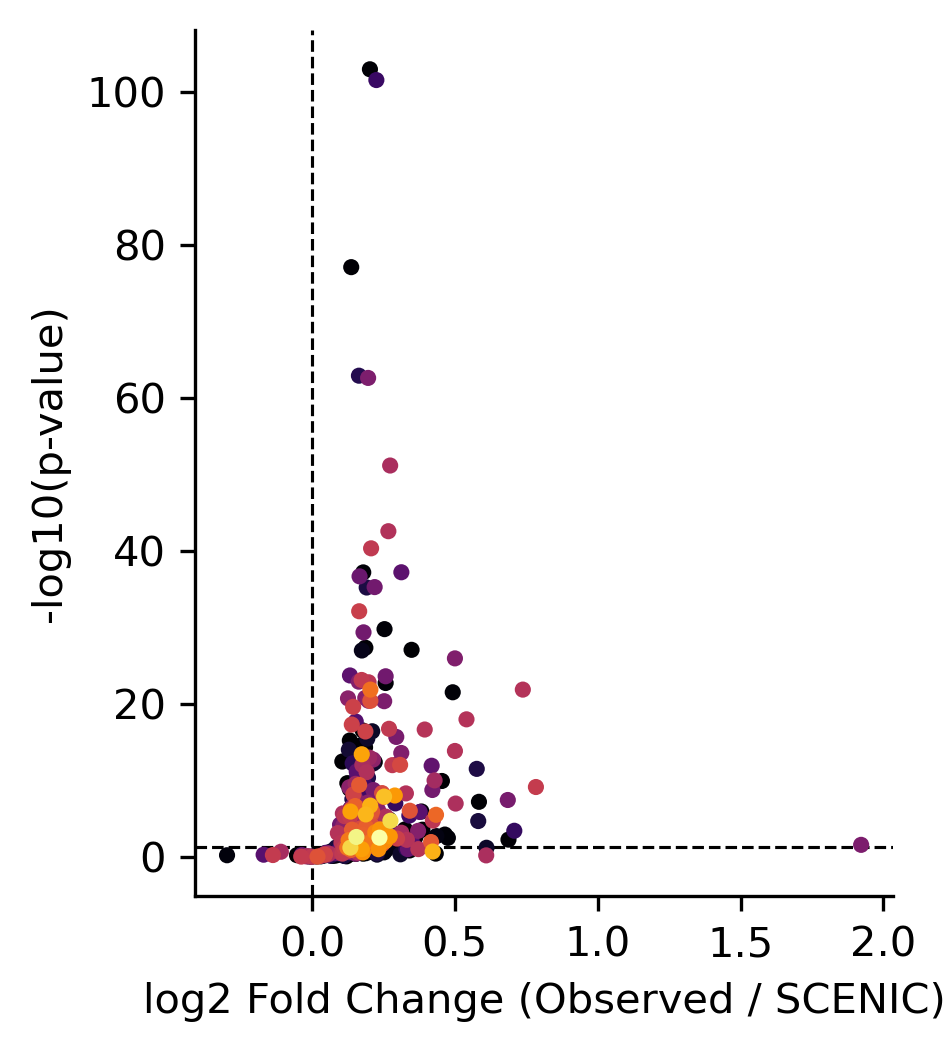

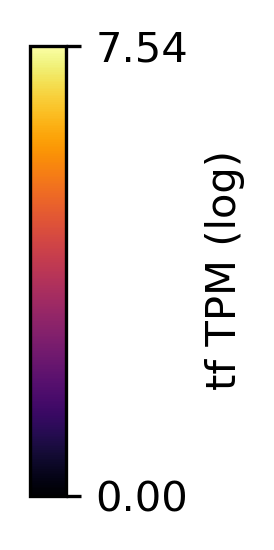

In [150]:
plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = 3, 3.75

pdf = results.copy()
pdf = pdf[pdf['tf_is_core']]
pdf['lfc_over_global'] = np.log2(pdf['observed_score'] / pdf['scenic_score'])
pdf['lfc_over_unobs'] = np.log2(pdf['observed_score'] / pdf['unobserved_score'])
pdf['group_expression_log'] = np.log1p(pdf['group_expression'])
pdf['tf_expression_log'] = np.log1p(pdf['tf_expression'])

# Transform p-values to -log10(p-value)
pdf['-log10_p_value'] = -np.log10(pdf['p_value_over_global'])

# Set p-value threshold
p_value_threshold = 0.05

# Create the volcano plot
sns.scatterplot(
    data=pdf.sort_values(by='tf_expression_log'),
    x='lfc_over_global',
    y='-log10_p_value',
    ec='none',
    hue='tf_expression_log',
    s=15,
    palette='inferno',
    legend=False,
)

# Add axis labels and title
plt.xlabel('log2 Fold Change (Observed / SCENIC)')
plt.ylabel('-log10(p-value)')

# Add horizontal line for p-value threshold
lfc_threshold = 0.0
plt.axhline(y=-np.log10(p_value_threshold), color='k', linestyle='--', linewidth=0.75, zorder=0)
plt.axvline(x=lfc_threshold, color='k', linestyle='--', linewidth=0.75, zorder=0)

sns.despine()
plt.show()

reload(plt2)
plt2.make_colorbar(
    cmap='inferno',
    width=0.15,
    height=2.5,
    title='tf TPM (log)',
    orientation='vertical',
    tick_labels=[f"{pdf['tf_expression_log'].min():.2f}",
                f"{pdf['tf_expression_log'].max():.2f}"],
)

query.shape=(239, 17)


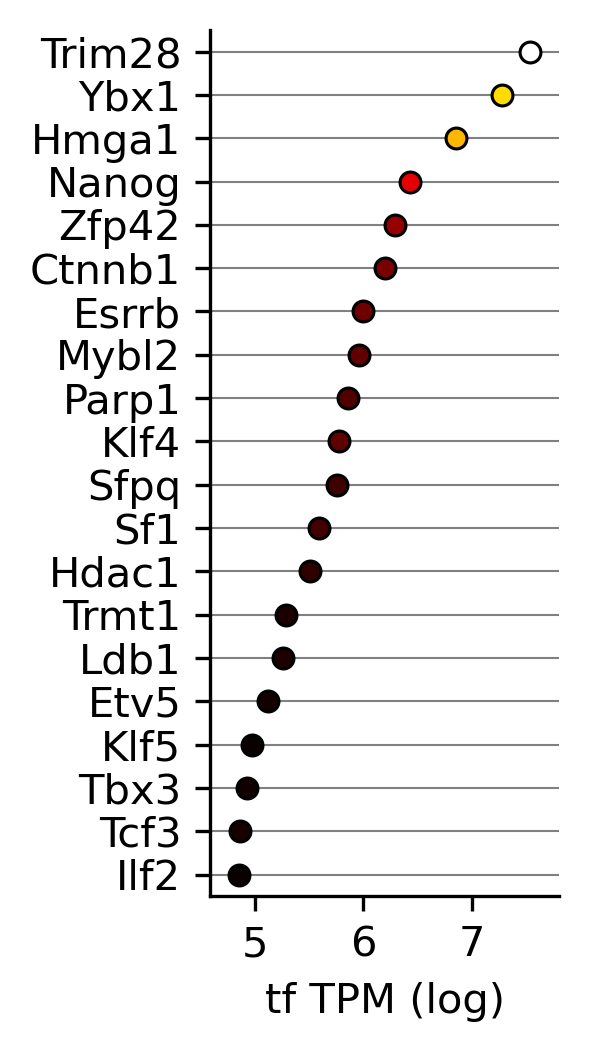

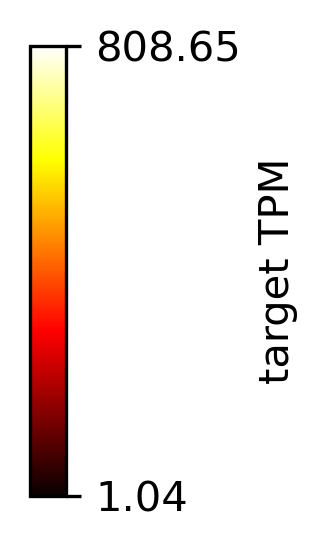

In [153]:
n_plot = 20
query = pdf[(pdf['-log10_p_value'] > -np.log10(p_value_threshold))]
query = query.sort_values(by='tf_expression', ascending=False)
print(f"{query.shape=}")

cmap = 'hot'

plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = 1.5, 3.75

sns.stripplot(
    data=query.head(n_plot),
    y='tf',
    x='tf_expression_log',
    hue='group_expression',
    edgecolor='k',    
    palette=cmap,
    size=5,
    linewidth=0.75,
    legend=False,
)

# Get the y-tick labels
yticklabels = plt.gca().get_yticklabels()

plt.grid(axis='y', color='grey', linestyle='-', linewidth=0.5)
plt.margins(x=0.1)
plt.ylabel('')
plt.xlabel('tf TPM (log)')
sns.despine()
plt.show()

reload(plt2)
plt2.make_colorbar(
    cmap=cmap,
    width=0.15,
    height=2.5,
    title='target TPM',
    orientation='vertical',
    tick_labels=[f"{query['group_expression'].min():.2f}",
                f"{query['group_expression'].max():.2f}"],
)


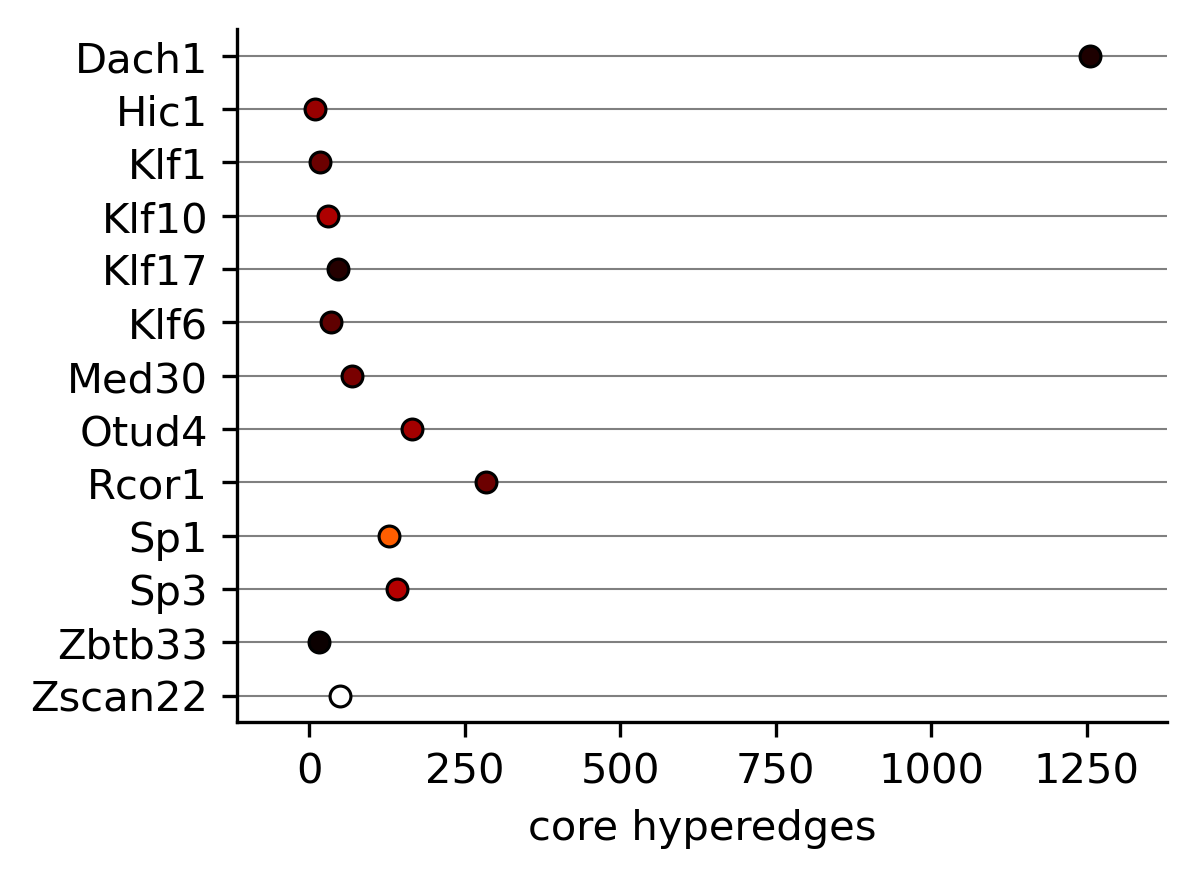

In [124]:
cmap = 'hot'

sns.stripplot(
    data=query,
    y='tf',
    x='n_hyperedges',
    hue='group_expression',
    edgecolor='k',    
    palette=cmap,
    size=5,
    linewidth=0.75,
    legend=False,
)

# Get the y-tick labels
yticklabels = plt.gca().get_yticklabels()

plt.grid(axis='y', color='grey', linestyle='-', linewidth=0.5)
plt.margins(x=0.1)
plt.ylabel('')
plt.xlabel('core hyperedges')
sns.despine()
plt.show()

In [155]:
database = 'celltypes'
edf = gget.enrichr(query['tf'].to_list(), database=database)
edf[['path_name', 'adj_p_val', 'overlapping_genes']]

Sat Jan 11 13:04:34 2025 INFO Performing Enichr analysis using database PanglaoDB_Augmented_2021. 
    Please note that there might a more appropriate database for your application. 
    Go to https://maayanlab.cloud/Enrichr/#libraries for a full list of supported databases.
    


,path_name,adj_p_val,overlapping_genes
0,Embryonic Stem Cells,5.069240e-07,"[TEAD4, SMAD1, RBFOX2, ESRRB, LEF1, STAT3, KLF..."
1,Luminal Epithelial Cells,1.753198e-02,"[EHF, KLF5, HMGA1, ESR1, GRHL2, OVOL2, LTF, SP..."
2,Cardiac Stem And Precursor Cells,1.753198e-02,"[TEAD4, RBFOX2, GATA4, NKX2-5, TBX3, GLI2, TEAD3]"
3,Adipocyte Progenitor Cells,1.753198e-02,"[HOXC5, PPARG, GLI1, HOXC8, TBX3, GLI2, TEAD3]"
4,Microfold Cells,2.420051e-02,"[EHF, KLF5, ONECUT2, NFIC, BCL3, KLF4, RELB]"
...,...,...,...
145,NK Cells,8.729431e-01,[TBX21]
146,Enteric Neurons,8.828576e-01,[AHDC1]
147,Monocytes,8.924937e-01,[SPI1]
148,Platelets,9.309279e-01,[SPI1]


In [156]:
edf['overlapping_genes'].values[0]

['TEAD4',
 'SMAD1',
 'RBFOX2',
 'ESRRB',
 'LEF1',
 'STAT3',
 'KLF4',
 'GLI2',
 'TRIM28',
 'ZFP42',
 'ZSCAN10',
 'BCL3',
 'CTNNB1',
 'NANOG',
 'TEAD3']

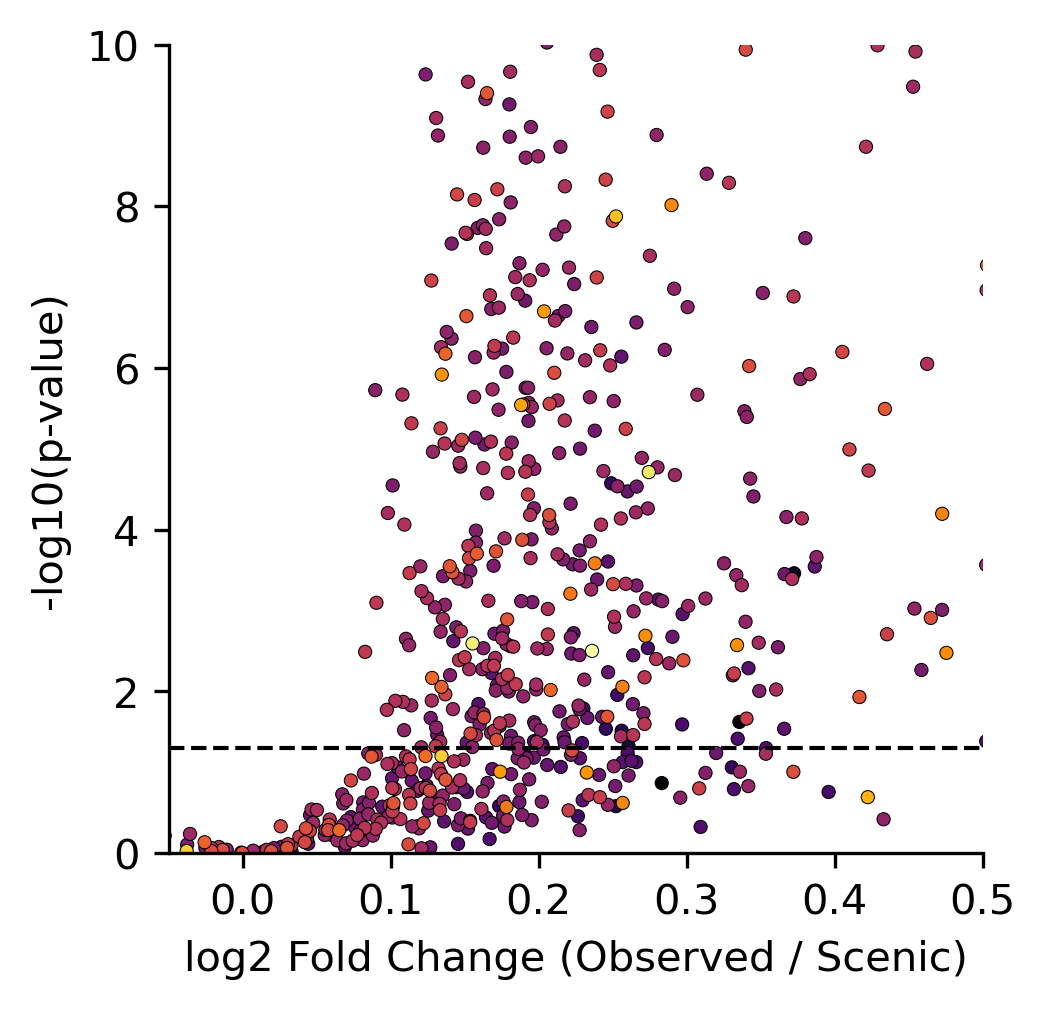

In [68]:
plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = 3.5, 3.5

pdf = results.copy()
pdf['lfc_over_global'] = np.log2(pdf['observed_score'] / pdf['scenic_score'])
pdf['lfc_over_unobs'] = np.log2(pdf['observed_score'] / pdf['unobserved_score'])
pdf['group_expression_log'] = np.log1p(pdf['group_expression'])


# Transform p-values to -log10(p-value)
pdf['-log10_p_value'] = -np.log10(pdf['p_value_over_global'])

# Set p-value threshold
p_value_threshold = 0.05

# Create the volcano plot
sns.scatterplot(
    data=pdf.sort_values(by='group_expression_log'),
    x='lfc_over_global',
    y='-log10_p_value',
    ec='k',
    hue='group_expression_log',
    s=10,
    palette='inferno',
    legend=False,
)

# Add axis labels and title
plt.xlabel('log2 Fold Change (Observed / Scenic)')
plt.ylabel('-log10(p-value)')

# Add horizontal line for p-value threshold
plt.axhline(y=-np.log10(p_value_threshold), color='k', linestyle='--', linewidth=1)
plt.xlim([-0.05, 0.5])
plt.ylim([0, 10])
sns.despine()

plt.show()

In [ ]:
plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = 1.5, 2

sns.boxplot(
    data=results,
    x='tf_is_core',
    y=results['read_tf_score'] - results['mean_tf_score'],
    linecolor='k',
    showfliers=False,
    width=0.5,
    palette=['lightgrey', 'red'],
)

# plt.xlabel('tf in core')
# plt.ylabel('mean TPM')

sns.despine()

In [ ]:
break

In [ ]:
sns.scatterplot(
    data=results,
    x='tf_expression',
    y='group_expression',
    hue='tf_is_core',
)

plt.yscale('log')
plt.xscale('log')

In [ ]:
df[df['gene_name'].isin(sdf.columns)]